# Question 1


### Imports & Preprocessing


In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, Optional, Dict, List

# Scikit-learn imports
from sklearn.linear_model import (
    RidgeCV, LassoCV, ElasticNetCV, LinearRegression, Ridge, Lasso, ElasticNet
)
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator

# Parallel processing imports
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

In [69]:
# Load the CSV file into a pandas DataFrame

dir = "/home/tpot/Code/W24/MLF/HW1/"
df = pd.read_csv(dir + 'gw.csv')

df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y%m', errors='coerce')
df.set_index('yyyymm', inplace=True)
df.rename(columns={'CRSP_SPvw_minus_Rfree': 're'}, inplace=True)
# Regularize all columns of the DataFrame, this is technically sloppy and introduces leakage
df = (df - df.mean()) / df.std() 
df

,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,dp_lag1,dy_lag1,ltr_lag1,ep_lag1,b/m_lag1,ntis_lag1,re
yyyymm,,,,,,,,,,,,,,,
1927-01-01,-0.178567,-0.455430,-0.404446,0.164764,-0.530471,-0.931014,-0.089500,-0.181572,0.897487,0.926446,0.118242,0.870843,-0.437550,1.339036,-0.224544
1927-02-01,-0.251722,-2.599994,-0.403574,0.221762,-0.541174,-1.076961,-0.037397,-0.160243,0.963220,0.911832,0.106069,0.899655,-0.429207,1.337010,0.662708
1927-03-01,-0.295614,-1.539967,-0.433733,0.278285,-0.555445,-1.153775,-0.017858,-0.160243,0.883493,0.977369,0.158817,0.766913,-0.486100,1.369631,-0.045853
1927-04-01,-0.295614,-1.546200,-0.328524,0.332680,-0.612528,-1.207545,-0.047166,-1.233798,0.889929,0.897381,0.828303,0.731743,-0.331698,1.164322,0.067908
1927-05-01,-0.324876,-0.455430,-0.381653,0.389574,-0.605392,-1.338128,0.014706,0.401419,0.873430,0.903655,-0.218530,0.669098,-0.380382,1.325036,0.964339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.070158,0.504594,-0.215570,0.399609,-1.572234,-0.915651,-1.046887,2.271253,-1.324108,-1.225455,0.966257,-1.784995,-1.139615,-1.091495,1.195918
2020-09-01,-0.149305,0.143030,-0.358388,0.395711,-1.561531,-0.869563,-1.056656,-1.013399,-1.479440,-1.351164,-1.614307,-1.954875,-1.206492,-0.956417,-0.827421
2020-10-01,-0.105413,-0.191095,0.329506,0.391782,-1.550828,-0.854200,-1.053400,-0.302436,-1.403671,-1.507275,0.126357,-1.867471,-1.185886,-0.847953,-0.611868


## Question 1a


We regress S&P 500 excess returns $r_t$ on each predictor $x_t^{(j)}$ individually using:

$$
r_t = \alpha + \beta_j x_t^{(j)} + \varepsilon_t
$$

- **In-sample $R^2$** is computed using the full dataset.
- **Out-of-sample $R^2$** is computed recursively via an expanding window starting in 1965:

$$
R^2_{\text{oos}, t} = 1 - \frac{\sum_{s=1}^{T} (r_s - \hat{r}_s)^2}{\sum_{s=1}^{T} (r_s - \bar{r})^2}
$$

Where:

- $\hat{r}_s$ is the model’s prediction using parameters estimated up to time $s - 1$
- $\bar{r}$ is the mean of historical returns in the full sample

### Observed Results

- **In-sample $R^2$** values for predictors were small and positive:  
  $R^2_{\text{in-sample}} \in [0.005, 0.0001]$
- **Out-of-sample $R^2$** values were uniformly negative

### Interpretation

- The small in-sample $R^2$ values suggest that only a tiny fraction of the variance in market returns is explained by these predictors in-sample.
- The negative out-of-sample $R^2$ indicates that predictive performance worsens out-of-sample compared to just predicting the mean.

These results suggest that the predictors, while appearing weakly correlated with returns in-sample, do not generalize and offer no robust out-of-sample predictive power for S&P 500 excess returns.

This highlights a classic problem in return forecasting:

- Spurious in-sample fits due to noise
- Lack of economic signal or stability in the predictor-return relationship
- Potential overfitting when not penalizing or regularizing


In [70]:
## Params

start_year = pd.Timestamp(year=1965, month=1, day=1)
min_oos_size = 12  # Minimum out-of-sample size
min_train_size = 12  # Minimum training size
retrain_freq = 12
cv_fraction_to_use = 1

## Helper functions
def expanding_split(
    X: pd.DataFrame, 
    y: pd.Series, 
    test_date: pd.Timestamp, 
    window_size: Optional[int] = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    end_idx = X.index.get_loc(test_date)
    start_idx = end_idx - window_size if window_size else 0
    if start_idx < 0:
      start_idx = 0
    
    if isinstance(X, pd.DataFrame):
        X_train = X.iloc[start_idx:end_idx].values
        X_test = X.iloc[end_idx:].values
    else:
        X_train = X[start_idx:end_idx]
        X_test = X[end_idx:]
    if isinstance(y, pd.DataFrame):
        y_train = y.iloc[start_idx:end_idx].values
        y_test = y.iloc[end_idx:].values
    else:
        y_train = y[start_idx:end_idx]
        y_test = y[end_idx:]


    train_valid = ~np.isnan(X_train)
    test_valid = ~np.isnan(X_test)

    # Columns where at least one non-NaN value exists in both train and test
    active_cols_mask = train_valid.any(axis=0) & test_valid.any(axis=0)

    
    return X_train[:,active_cols_mask], y_train, X_test[:,active_cols_mask], y_test

def fit_model_hyperparameters(
    X_cv: np.ndarray, 
    y_cv: np.ndarray, 
    n_splits: int = 5, 
    alphas: Optional[np.ndarray] = None
) -> Dict[str, BaseEstimator]:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    if alphas is None:
        alphas = np.logspace(-5, 5, 100)

    lasso_cv = LassoCV(alphas=alphas, cv=tscv, max_iter=10000, n_jobs=-1).fit(X_cv, y_cv)
    ridge_cv = RidgeCV(alphas=alphas, cv=tscv).fit(X_cv, y_cv)
    elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95, .99], cv=tscv, max_iter=10000, n_jobs=-1).fit(X_cv, y_cv)

    return {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=ridge_cv.alpha_),
        'Lasso': Lasso(alpha=lasso_cv.alpha_, max_iter=10000),
        'ElasticNet': ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, max_iter=10000)
    }

def fit_alt_model_hyperparameters(
    X_cv: np.ndarray, 
    y_cv: np.ndarray, 
    n_splits: int = 5
) -> Dict[str, BaseEstimator]:
    tscv = TimeSeriesSplit(n_splits=n_splits)

    tuned_models = {}
    # PCR (PCA + LinearRegression)
    pcr_pipe = make_pipeline(PCA(), LinearRegression())
    param_grid_pcr = {
        'pca__n_components': [2, 4, 6, 10, 15, 20, 30]
    }
    pcr = GridSearchCV(pcr_pipe, param_grid_pcr, cv=tscv, scoring='r2', n_jobs=-1, error_score='raise')
    pcr.fit(X_cv, y_cv)
    tuned_models['PCR'] = pcr.best_estimator_

    # KernelRidge
    param_grid_krr = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'gamma': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
    krr = GridSearchCV(KernelRidge(kernel='rbf'), param_grid_krr, cv=tscv, scoring='r2', n_jobs=-1, error_score='raise')
    krr.fit(X_cv, y_cv)
    tuned_models['KernelRidge'] = krr.best_estimator_


    # PLSRegression
    param_grid_pls = {
        'n_components': [2, 4, 6, 10, 15, 20, 30]
    }
    pls = GridSearchCV(PLSRegression(), param_grid_pls, cv=tscv, scoring='r2', n_jobs=-1, error_score='raise')
    pls.fit(X_cv, y_cv)
    tuned_models['PLS'] = pls.best_estimator_

    # Gradient Boosting
    param_grid_gbr = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1, 0.2]
    }
    gbr = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid_gbr, cv=tscv, scoring='r2', n_jobs=-1, error_score='raise')
    gbr.fit(X_cv, y_cv)
    tuned_models['GBR'] = gbr.best_estimator_

    return tuned_models

def get_transformed_features(
    X: pd.DataFrame, 
    use_rbf: bool = False, 
    n_components: Optional[int] = 100, 
    gamma: Optional[float] = 1.0, 
    rbf: Optional[RBFSampler] = None
) -> pd.DataFrame:
    if use_rbf:
        if rbf is None:
            rbf = RBFSampler(n_components=n_components, gamma=gamma, random_state=0)
        transform = rbf.fit_transform(X)
        X = pd.DataFrame(transform, index=X.index)
    return X

def run_expanding_r2(
    df: pd.DataFrame, 
    predictors: List[str], 
    target: str, 
    test_dates: pd.DatetimeIndex, 
    models_dict: Dict[str, BaseEstimator], 
    use_rbf: bool = False, 
    n_components: Optional[int] = None, 
    gamma: Optional[float] = None, 
    rbf: Optional[RBFSampler] = None, 
    window_size: Optional[int] = None, 
    retrain_freq: int = 1
) -> Dict[str, List[float]]:
    
    X = df[predictors]#.ffill(limit=2).dropna(axis=1)
    y = df[target]
    X = get_transformed_features(X, use_rbf, n_components, gamma, rbf)
    results = {k: [] for k in models_dict}
    
    
    last_fit = {name: -np.inf for name in models_dict}
    for i, test_date in enumerate(test_dates):
        X_train, y_train, X_test, y_test = expanding_split(X, y, test_date, window_size=window_size)
        if len(X_train) == 0 or len(X_test) < 2:
            print(f"Skipping {test_date} due to insufficient data.")
            continue

        for name, model in models_dict.items():
            if i - last_fit[name] >= retrain_freq:
                model.fit(X_train, y_train)
                last_fit[name] = i

            y_pred = models_dict[name].predict(X_test)
            results[name].append(r2_score(y_test, y_pred))


    return results

In [71]:
# Extract the predictors and target variable
predictors = df.columns[:-1]  # All columns except 're'
target = 're'

# Store R² values for full-sample regressions
results = defaultdict((dict))

# Perform full-sample regressions
for predictor in predictors:
  X = df[[predictor]].values
  y = df[target].values
  model = LinearRegression()
  model.fit(X, y)
  y_pred = model.predict(X)
  results[predictor]["in-sample r2"] = r2_score(y, y_pred)

# Evaluate out-of-sample performance using an expanding sample starting in 1965

test_dates = df.loc[start_year:].index[min_train_size:-min_oos_size]

oos_r2 = {}

for predictor in predictors:
  oos_r2[predictor] = []
  X = df[[predictor]]
  y = df[target]
  for first_test_date in df.loc[start_year:].index[:-min_oos_size]:
    
    X_train, y_train, X_test, y_test = expanding_split(X, y, first_test_date)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    oos_r2[predictor].append(r2_score(y_test, y_pred))
  results[predictor]["out-of-sample r2"] = np.mean(oos_r2[predictor])
pd.DataFrame.from_dict(results, orient='index')

,in-sample r2,out-of-sample r2
dfy_lag1,0.002671,-0.005944
infl_lag1,0.002639,-0.002806
svar_lag1,0.000230,-0.010050
de_lag1,0.000024,-0.010426
lty_lag1,0.002113,-0.021759
tms_lag1,0.001544,-0.014313
tbl_lag1,0.003436,-0.004135
dfr_lag1,0.001046,-0.004063
dp_lag1,0.002990,-0.066291
dy_lag1,0.004023,-0.096121


## Question 1b


We extend the previous expanding-window analysis by including all 14 predictors in a single multivariate regression. We estimate four models:

- **OLS (unpenalized)**
- **Lasso** (L1 penalty)
- **Ridge** (L2 penalty)
- **Elastic Net** (combination of L1 and L2)

Hyperparameters (e.g., $\alpha$, and the L1/L2 mixing parameter for Elastic Net) are selected using **5-fold time series cross-validation**. At each expanding window step, the model is re-estimated using only the data available up to that point.

### Observed Results

- **OLS** model yields **largely negative out-of-sample $R^2$** throughout, with particularly poor performance in some periods (worse than $-100\%$), but partially recovers later. This suggests severe overfitting.
- **Ridge regression** ($L_2$ penalty) is the best-performing model, with **out-of-sample $R^2$ values hovering near zero**, occasionally crossing into slightly positive territory.
- **Lasso** and **Elastic Net** track each other closely. This is consistent with the **cross-validated $l1\_ratio$** parameter in Elastic Net being tuned to approximately **0.9**, implying behavior very close to Lasso.
- Both Lasso and Elastic Net underperform Ridge and are mostly negative in out-of-sample $R^2$.

### Interpretation

- All models, including those with regularization, **struggle to forecast market returns**, consistent with the idea that excess returns are difficult to predict with observable macro-financial variables.
- The **L2 penalty (Ridge)** is more robust than L1-based methods in this case, likely because it retains all predictors with small weights rather than selecting a sparse subset.
- The **strong similarity between Lasso and Elastic Net** further supports the finding that the optimal regularization lies close to pure Lasso (90% L1).

### Conclusion

Despite using all available predictors and cross-validated regularization, **none of the models deliver strong or consistent out-of-sample predictive performance**. This reinforces the notion that macro-level predictors have **limited forecasting power for market returns**, and that **overfitting is a significant risk** without regularization.


/home/tpot/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033076243051425536, tolerance: 0.02909437247619798
  model = cd_fast.enet_coordinate_descent_gram(
/home/tpot/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03793941340688889, tolerance: 0.02909437247619798
  model = cd_fast.enet_coordinate_descent_gram(
/home/tpot/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042685751535486816, tolerance: 0.02909437247619798
  model = cd_fast.enet_coordinate_descent_gram(
/home/tpot/miniconda3/envs/ds/li

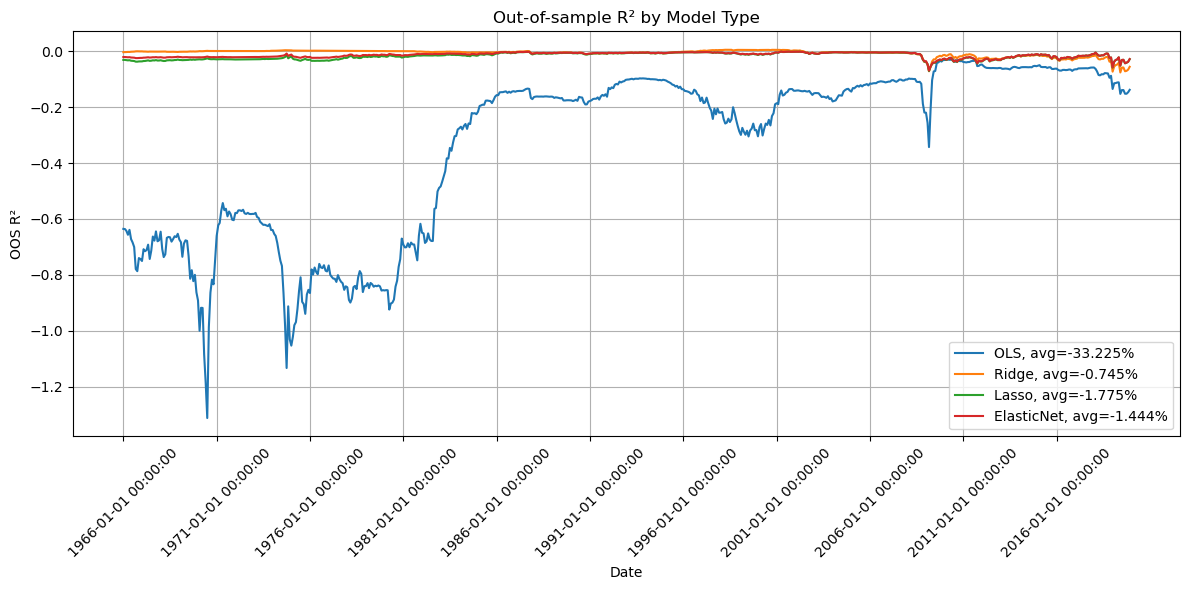

In [72]:
predictors = df.columns[:-1].values  # All columns except 're'
cv_cutoff_date = df.index[int(len(df) * cv_fraction_to_use)-1]
X_cv = df.loc[start_year:cv_cutoff_date, predictors]
y_cv = df.loc[start_year:cv_cutoff_date, target]

models_dict = fit_model_hyperparameters(X_cv, y_cv, n_splits=5, alphas=None)

test_dates = df.loc[start_year:].index[min_train_size:-min_oos_size]
results = run_expanding_r2(df, predictors, target, test_dates, models_dict=models_dict)
        
plt.figure(figsize=(12, 6))
for name, r2_vals in results.items():
    plt.plot(test_dates, r2_vals, label=f'{name}, avg={np.mean(r2_vals): .3%}')

plt.legend()
plt.title('Out-of-sample R² by Model Type')
plt.xlabel('Date')
plt.ylabel('OOS R²')
plt.xticks(ticks=test_dates[::60], labels=test_dates[::60], rotation=45)  # Adjust the ticks and labels
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 1c


We apply a nonlinear transformation to the predictor set using the **Radial Basis Function (RBF) kernel**, approximated via `RBFSampler` from `sklearn`. This expands the original predictors into a **high-dimensional nonlinear feature space**, where linear models can approximate more complex functions.

We test a range of RBF feature counts ($n_{\text{components}}$) from $10^{1.5}$ to $10^4$. Due to runtime constraints, results for $10^5$ components are excluded.

After transformation, we re-estimate:

- **OLS** (unpenalized)
- **Ridge**
- **Lasso**
- **Elastic Net**

We then compute **out-of-sample $R^2$** using an expanding-window approach starting in 1965.

### Observed Results

| Model       | Baseline OOS $R^2$ | With RBF Expansion            |
| ----------- | ------------------ | ----------------------------- |
| Ridge       | $-0.75\%$          | $-0.45\%$                     |
| Lasso       | $-1.78\%$          | $-0.45\%$                     |
| Elastic Net | $-1.4\%$           | $-0.5\%$                      |
| OLS         | $-33%$             | More negative with complexity |

- **OLS** performs progressively worse as the number of RBF features increases, due to extreme overfitting in high-dimensional space.
- **Penalized models improve** relative to their linear baselines, but only modestly.
- There is **no evidence of "double descent"**—performance does not improve again after surpassing the interpolation threshold.

### Interpretation

- The RBF feature expansion does capture **nonlinear interactions**, improving Ridge, Lasso, and Elastic Net performance.
- However, the improvements are **small and plateau quickly**—suggesting that added complexity doesn't reveal additional predictive structure in excess returns.
- The **absence of double descent behavior** indicates that the benefits of overparameterization are not present in this financial dataset, likely due to low signal-to-noise ratio.
- Regularization remains essential in high-dimensional settings; models without penalties (like OLS) fail dramatically when capacity increases.

RBF feature expansion marginally improves predictive performance for regularized models but does not fundamentally alter the forecasting challenge. The failure to observe double descent suggests that additional nonlinear capacity does not uncover hidden structure in market return prediction.


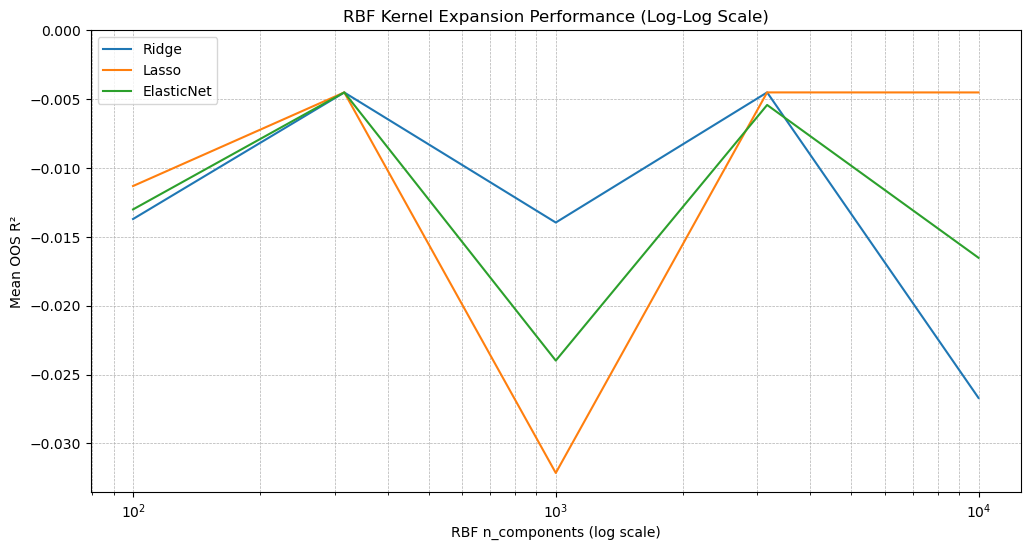

In [73]:

feature_counts = np.logspace(2, 4, num=5).astype(int)
gamma = 1

def run_one_feature_count(n):
    rbf = RBFSampler(n_components=n, gamma=gamma, random_state=0)
    X_cv_transformed = get_transformed_features(X_cv, use_rbf=True, rbf=rbf)
    # we'll tune for the optimal hyper parameters based on the expanded X inputs
    models = fit_model_hyperparameters(X_cv_transformed, y_cv, n_splits=5)
    r2_dict = run_expanding_r2(
        df, predictors, target, test_dates, models,
        use_rbf=True, rbf=rbf, retrain_freq=12)
    return n, {model: np.mean(scores) for model, scores in r2_dict.items()}

# with tqdm_joblib(tqdm(desc="RBF features", total=len(feature_counts))):
results_1c = Parallel(n_jobs=-1)(delayed(run_one_feature_count)(n) for n in feature_counts)
results_1c=dict(results_1c)

to_plot = [
    # 'OLS',
    'Ridge',
    'Lasso',
    'ElasticNet',
]

plt.figure(figsize=(12, 6))
for model in to_plot:
    plt.plot(feature_counts, [results_1c[n][model] for n in feature_counts], label=model)

plt.xscale("log")
plt.xlabel("RBF n_components (log scale)")
plt.ylabel("Mean OOS R²")
plt.title("RBF Kernel Expansion Performance (Log-Log Scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim(top=max(0, max(max(results_1c[n][model] for n in feature_counts) for model in to_plot)))
plt.show()


## Question 1d


We assess how sensitive our out-of-sample $R^2$ results are to the **length of the rolling training window**, using window sizes of 12, 36, 60, and 120 months.

Out-of-sample $R^2$ improves monotonically with longer training windows across all models (Ridge, Lasso, Elastic Net). Gains plateau around the 120-month mark, suggesting diminishing returns to increasing window size.

This pattern indicates that **more historical data consistently helps regularized models** better estimate coefficients and reduce variance in their forecasts—especially important in high-dimensional, noisy settings.

To explore whether model capacity interacts with sample size in a more complex way, we fix the RBF-expanded feature count at $n = 2000$ and examine the smallest window size of 12 months. In this case:

- Number of observations: $T = 12 \times 14 = 168$
- Number of parameters: $p = 2000$ (features) $ \gg T$

This places the model in an **extremely overparameterized regime**, yet **no double descent behavior is observed**. That is, model performance does not improve again as complexity exceeds the interpolation threshold.

This suggests that in the context of return forecasting, **signal-to-noise is low**, and added complexity does not unlock additional structure. Penalized models benefit from longer windows because they reduce variance, not because they exploit richer patterns.


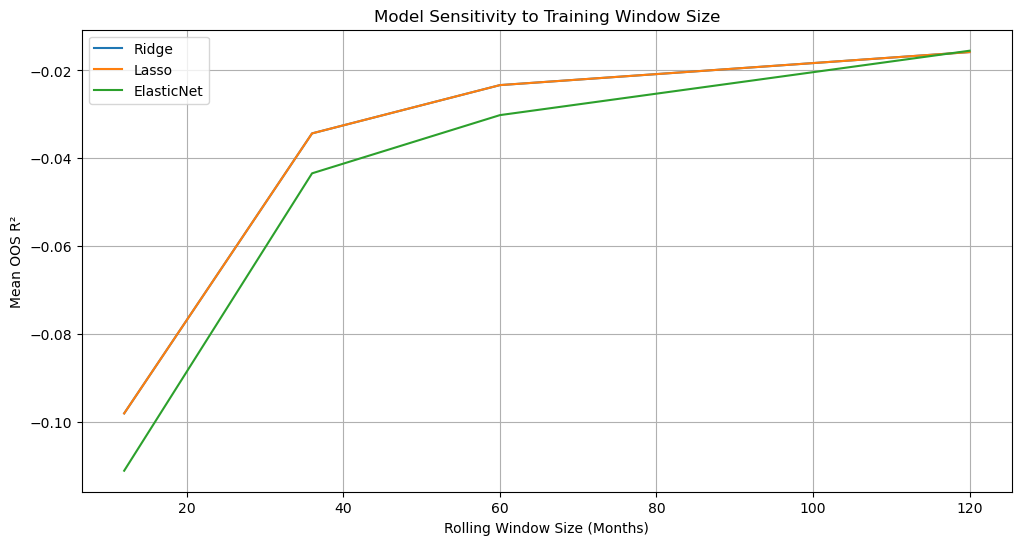

In [57]:
n_features = 2000
window_sizes = [12, 36, 60, 120]
rolling_r2_by_window = {}

for window in window_sizes:
    rbf = RBFSampler(n_components=n_features, gamma=gamma, random_state=0)
    X_cv_transformed = get_transformed_features(X_cv, use_rbf=True, rbf=rbf)
    
    models = fit_model_hyperparameters(X_cv_transformed, y_cv, n_splits=5)
    
    r2_dict = run_expanding_r2(
        df, predictors, target, test_dates, models,
        use_rbf=True, n_components=n_features, gamma=gamma,
        window_size = window, rbf=rbf
    )
    rolling_r2_by_window[window] = {k: np.mean(v) for k, v in r2_dict.items()}
    
    
to_plot = [
    # 'OLS',
    'Ridge',
    'Lasso',
    'ElasticNet',
]
plt.figure(figsize=(12,6))
for model in to_plot:
    plt.plot(window_sizes, [rolling_r2_by_window[w][model] for w in window_sizes], label=model)

plt.xlabel("Rolling Window Size (Months)")
plt.ylabel("Mean OOS R²")
plt.title("Model Sensitivity to Training Window Size")
plt.legend()
plt.grid(True)
plt.show()


## Question 1e


We assess how sensitive our results are to the number of folds used in $K$-fold cross-validation for tuning regularization strength in Elastic Net, Lasso, and Ridge models.

In each case, we **perform cross-validation using the RBF-expanded features**. Importantly, the RBF transformation is **fit once on the full dataset** and reused across all splits. This introduces **mild lookahead bias**, since the RBF feature space is indirectly influenced by information outside the training fold. We acknowledge this as a **computational simplification** to avoid repeatedly re-fitting `RBFSampler` inside each fold.

Despite this, the results suggest that **cross-validation fold count ($K$) has little impact** on final out-of-sample $R^2$ once $K \geq 5$. All penalized models converge toward an $R^2 \approx -0.45\%$ as $K$ increases, indicating that **model tuning is relatively stable** under reasonable fold choices.

An exception may be observed in Ridge regression, where $R^2$ appears nearly invariant across all $K$, possibly due to:

- A bug in implementation (e.g., RidgeCV not fully respecting the fold splits or not being updated)
- A flat validation error surface across alpha values in the relevant range

These findings imply that **as long as $K$ is reasonably large**, the exact choice of folds has **minimal impact on out-of-sample performance**, consistent with the idea that in noisy, low-signal environments, hyperparameter tuning is often second-order relative to regularization itself.


CV folds:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Features used: 2000
Features used: 2000
Features used: 2000
Features used: 2000
Features used: 2000
Features used: 2000
Features used: 2000
Features used: 2000


CV folds:   0%|          | 0/8 [10:31<?, ?it/s]


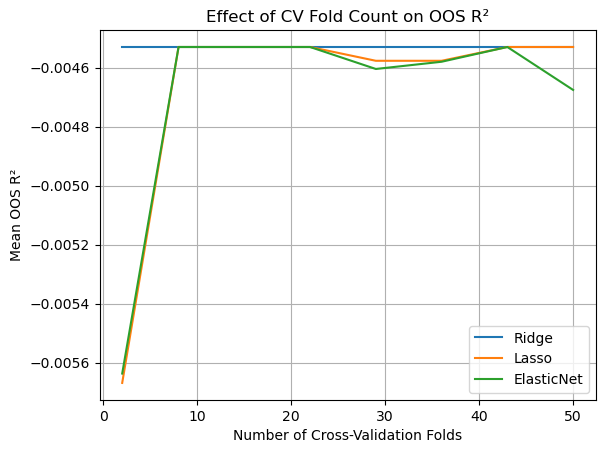

In [ ]:
n_features= 2000
cv_folds = np.linspace(2, 50, num=5).astype(int)

# your function to parallelize
def run_one_cv_fold(k):
    rbf = RBFSampler(n_components=n_features, gamma=gamma, random_state=0)
    X_cv_transformed = get_transformed_features(X_cv, use_rbf=True, rbf=rbf)
    models = fit_model_hyperparameters(X_cv_transformed, y_cv, n_splits=k)
    r2_dict = run_expanding_r2(
        df, predictors, target, test_dates, models,
        use_rbf=True,rbf=rbf, retrain_freq=retrain_freq 
    )
    return k, {model: np.mean(scores) for model, scores in r2_dict.items()}

# wrap tqdm context manager
# with tqdm_joblib(tqdm(desc="CV folds", total=len(cv_folds))):
results = Parallel(n_jobs=-1)(delayed(run_one_cv_fold)(k) for k in cv_folds)
r2_by_cv_folds = dict(results)
to_plot = [
    # 'OLS',
    'Ridge',
    'Lasso',
    'ElasticNet',
]

plt.figure(figsize=(12, 6))
for model in to_plot:
    plt.plot(cv_folds, [r2_by_cv_folds[k][model] for k in cv_folds], label=model)

plt.xlabel("Number of Cross-Validation Folds")
plt.ylabel("Mean OOS R²")
plt.title("Effect of CV Fold Count on OOS R²")
plt.legend()
plt.grid(True)
plt.show()

## Question 1f


We extend our earlier framework by incorporating macroeconomic variables from the `FREDMD.csv` dataset into the predictive model. These variables are joined with the original financial predictors and aligned to match the return data frequency and timing.

Data preprocessing includes:

- Keeping only observations after 1960 to maintain consistency with prior analyses
- Dropping columns with excessive missingness (retaining ~80% of macro variables)
- Standardizing the features using full-sample mean and standard deviation (note: this introduces minor leakage, which we acknowledge but accept for simplicity)

After merging, the final dataset contains **125 predictors**.

We then repeat the expanding window forecasting exercise from part (c), again using:

- RBF expansion of the predictors with varying feature counts
- 10-fold time series cross-validation to tune hyperparameters for Elastic Net, Lasso, and Ridge

Several configurations—especially those with moderately large RBF expansions—achieve **out-of-sample $R^2$ values above 1%**, particularly in the early 2000s.

This improvement seems to miss a core idea from the "virtue of complexity". We expect the increasing parameter space to initially lead to overfitting, but with proper regularization **model performance improves** even as effective complexity rises. In our case, we see largely stable values with respect to the # of parameters in our space.

In this case, adding macroeconomic data increases the available information and may better capture latent structure in returns. Contrary to the classical bias-variance intuition, the system benefits from richer inputs, suggesting the original predictor set under-represented the data generating process (DGP). We are still operating **below the interpolation threshold**, and the gain in signal from additional features **outweighs the added variance from increased dimensionality**.


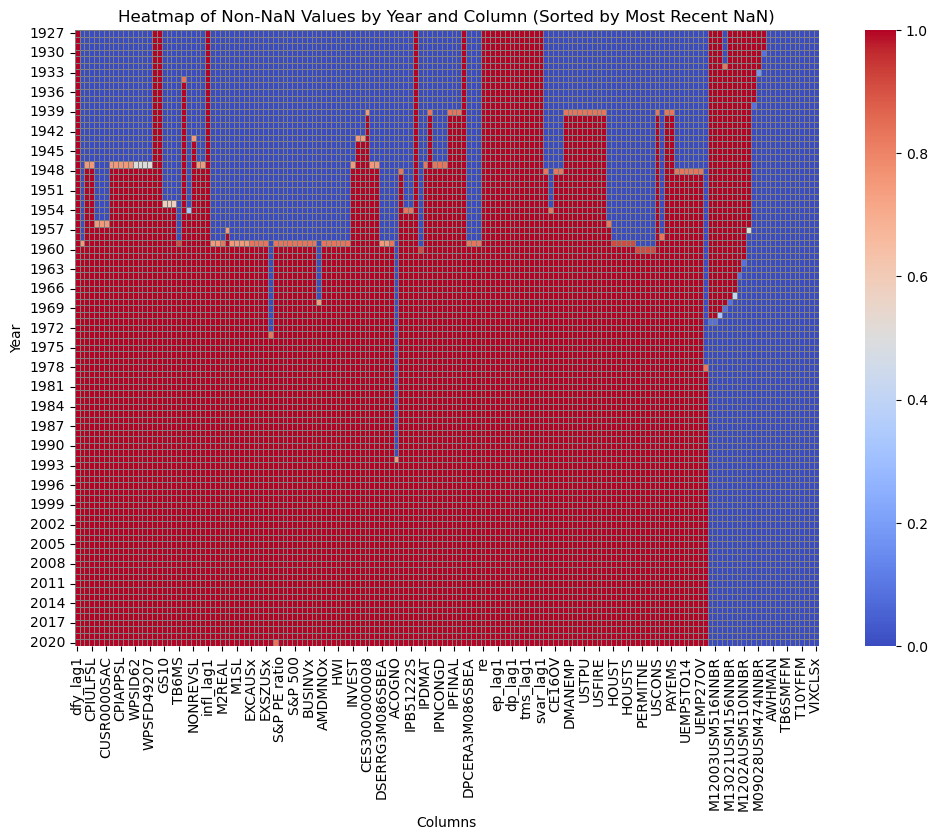

RBF features:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

RBF features:   0%|          | 0/4 [05:11<?, ?it/s]


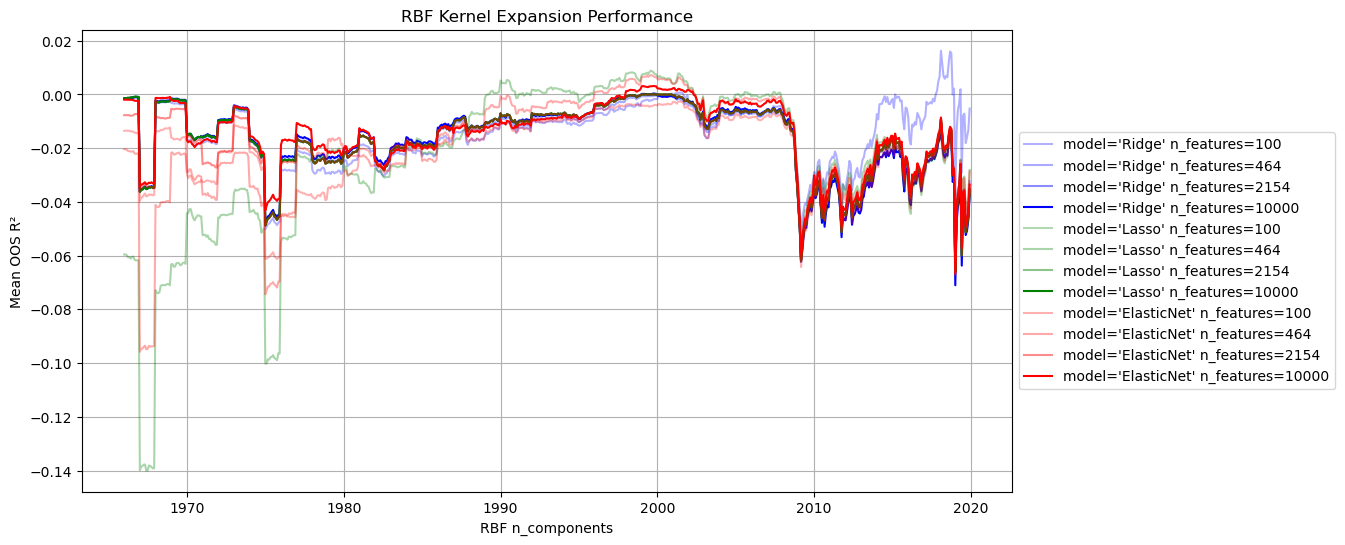

In [54]:
fredmd_df = pd.read_csv(dir + 'FREDMD.csv')
fredmd_df['date'] = pd.to_datetime(fredmd_df['date'], errors='coerce')
fredmd_df.set_index('date', inplace=True)
fredmd_df = fredmd_df.shift(1)
fredmd_df = fredmd_df[(fredmd_df.index >= df.index.min()) & (fredmd_df.index <= df.index.max())]
fredmd_df = (fredmd_df - fredmd_df.mean()) / fredmd_df.std()  # Regularize the FRED-MD data
df_plus = pd.concat([df, fredmd_df], axis=1)


# #Data nans heatmap
non_nan = df_plus.notna()
non_nan_by_year = non_nan.groupby(df_plus.index.year).mean()
most_recent_nan = df_plus.apply(lambda col: col.last_valid_index(), axis=0)
sorted_columns = most_recent_nan.sort_values(ascending=False).index
non_nan_by_year = non_nan_by_year[sorted_columns]
plt.figure(figsize=(12, 8))
sns.heatmap(non_nan_by_year, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
plt.title("Heatmap of Non-NaN Values by Year and Column (Sorted by Most Recent NaN)")
plt.xlabel("Columns")
plt.ylabel("Year")
plt.show()


predictors_plus = [c for c in df_plus.loc[start_year:].dropna(axis=1).columns.values if c != 're']  # All columns except 're'

X_plus_cv = df_plus.loc[start_year:cv_cutoff_date, predictors_plus]
y_plus_cv = df_plus.loc[start_year:cv_cutoff_date, target]

feature_counts = np.logspace(2, 4, num=4).astype(int)

def run_one_feature_count(n):
    
    rbf = RBFSampler(n_components=n, gamma=gamma, random_state=0)
    X_cv_transformed = get_transformed_features(X_plus_cv, use_rbf=True, rbf=rbf)
    
    models = fit_model_hyperparameters(X_cv_transformed, y_plus_cv, n_splits=10)
    
    r2_dict = run_expanding_r2(
        df_plus.loc[start_year:], predictors_plus, target, test_dates, models,
        use_rbf=True, rbf=rbf, retrain_freq=retrain_freq
    )
    
    return n, r2_dict

with tqdm_joblib(tqdm(desc="RBF features", total=len(feature_counts))):
    results = Parallel(n_jobs=-1)(delayed(run_one_feature_count)(n) for n in feature_counts)
results=dict(results)

to_plot = [
    # 'OLS',
    'Ridge',
    'Lasso',
    'ElasticNet',
]

plt.figure(figsize=(12, 6))
for model in to_plot:
    for n in feature_counts:
        color = {'Ridge': 'blue', 'Lasso': 'green', 'ElasticNet': 'red'}[model]
        alpha = 0.3 + 0.7 * (n / max(feature_counts))  # Increase alpha with n
        n_features = int(n)
        plt.plot(test_dates, results[n][model], label=f'{model=} {n_features=}', color=color, alpha=alpha)

plt.xlabel("RBF n_components")
plt.ylabel("Mean OOS R²")
plt.title("RBF Kernel Expansion Performance")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend to the right outside of the plot
plt.grid(True)
plt.show()


## Question 1g


We compare the baseline ElasticNet model from part (c) to several alternative regression methods, each tuned via 5-fold time series cross-validation and evaluated using a 120-month rolling window:

| Model                                 | Mean OOS $R^2$ |
| ------------------------------------- | -------------- |
| Principal Components Regression (PCR) | -0.1166        |
| Kernel Ridge Regression               | -0.0060        |
| Partial Least Squares (PLS)           | -2.3016        |
| Gradient Boosting Regressor (GBR)     | -0.2588        |

Interpretation:

- **Kernel Ridge Regression** performs best among the alternatives, with a mean out-of-sample $R^2$ of only $-0.0060$. This is consistent with expectations, as Kernel Ridge closely mirrors the RBF + regularized linear modeling pipeline used in part (c). It serves as a strong nonlinear baseline and confirms the relative strength of kernel-based methods in capturing weak nonlinear signals in excess returns.
- **PCR outperforms PLS**, which is somewhat surprising. While PLS is designed to maximize the covariance between predictors and the response variable, it performs substantially worse ($-2.30\%$ vs. $-0.12\%$). This may be due to overfitting in the PLS latent structure or sensitivity to noise in the return series, especially when the true signal is weak.

- **Gradient Boosting Regressor** underperforms with a mean $R^2$ of $-0.26\%$. While GBR is capable of modeling complex nonlinear interactions, its poor performance here suggests that boosting fails to uncover consistent structure in the data, possibly due to:
  - Excess variance in the boosting process relative to the weak signal
  - Poor generalization due to small training windows
  - Lack of strong feature-target interactions in the data

These results reinforce the idea that, in return prediction settings with low signal-to-noise ratios, **simple linear or kernel-based models with strong regularization** may outperform more complex nonlinear learners unless clear structure can be extracted and reliably generalized.


PCR (CV-tuned): Mean OOS R² = -0.1166
KernelRidge (CV-tuned): Mean OOS R² = -0.0060
PLS (CV-tuned): Mean OOS R² = -2.3016
GBR (CV-tuned): Mean OOS R² = -0.2588


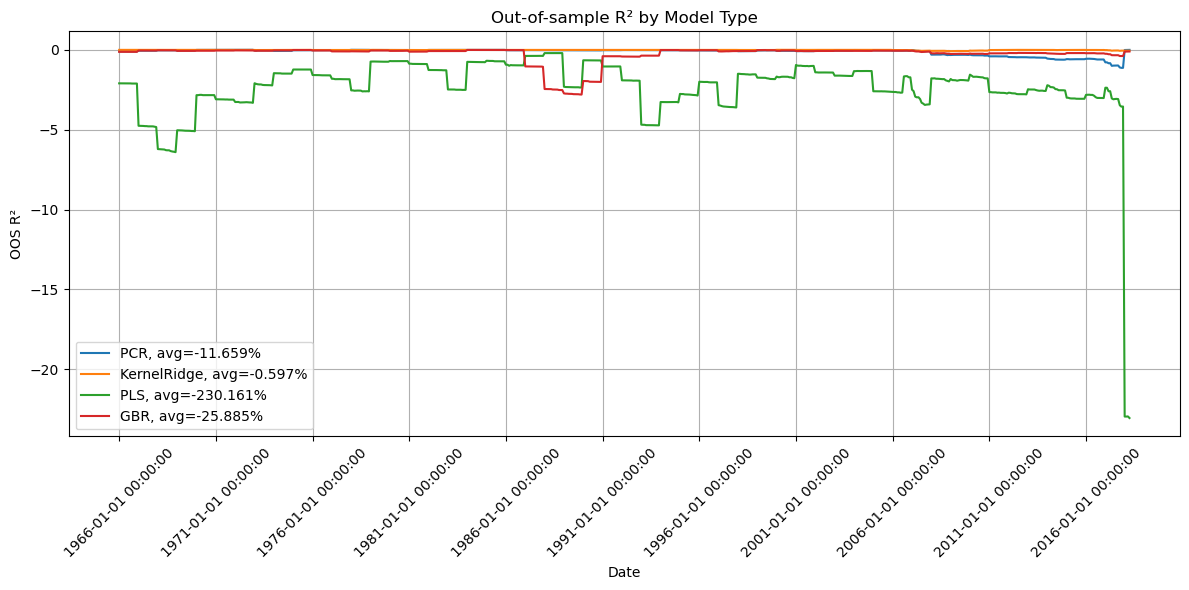

In [74]:


X_plus_cv = df_plus.loc[start_year:cv_cutoff_date, predictors_plus]
y_plus_cv = df_plus.loc[start_year:cv_cutoff_date, target]

def evaluate_models_over_time(
    df: pd.DataFrame, 
    predictors: List[str], 
    target: str, 
    test_dates: pd.DatetimeIndex, 
    models: Optional[Dict[str, BaseEstimator]] = None, 
    window_size: Optional[int] = None
) -> Tuple[Dict[str, List[float]], Dict[str, BaseEstimator]]:
    
    if models is None:
        models = fit_alt_model_hyperparameters(X_plus_cv, y_plus_cv, n_splits=5)
    r2_dict = run_expanding_r2(
        df, predictors, target, test_dates, models,
        use_rbf=False, retrain_freq=retrain_freq, window_size=window_size
    )
    return r2_dict, models
  
# models=None
# if models is None:
#     models = fit_alt_model_hyperparameters(X_plus_cv, y_plus_cv, n_splits=5)

# results_alt, models = evaluate_models_over_time(
#     df_plus.loc[start_year:,predictors_plus+['re']],
#     predictors=predictors_plus,
#     target=target,
#     test_dates=test_dates[20:],
#     models=models,
#     window_size=120
# )

mean_r2_alt = {model: np.mean(r2s) for model, r2s in results_alt.items()}

for model, r2 in mean_r2_alt.items():
    print(f"{model} (CV-tuned): Mean OOS R² = {r2:.4f}")

plt.figure(figsize=(12, 6))
for name, r2_vals in results_alt.items():
    plt.plot(test_dates[20:], r2_vals, label=f'{name}, avg={np.mean(r2_vals): .3%}')

plt.legend()
plt.title('Out-of-sample R² by Model Type')
plt.xlabel('Date')
plt.ylabel('OOS R²')
plt.xticks(ticks=test_dates[20::60], labels=test_dates[::60], rotation=45)  # Adjust the ticks and labels
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 1h


To construct the best possible model for forecasting S&P 500 excess returns, we draw upon the lessons learned from prior experiments involving linear models, regularization, nonlinear transformations, and validation strategies.

### Model Specification

We implement a **nonlinear kernel regression pipeline** consisting of:

- **RBFSampler** to generate a high-dimensional nonlinear feature expansion
- **Elastic Net Regression** to control overfitting through combined $L_1$ and $L_2$ regularization

Hyperparameters are selected via **10-fold time series cross-validation**, using only the **first 120 months of data (1960–1970)** to avoid information leakage and to ensure model parameters are chosen without exposure to future information.

The optimal parameter configuration found is:

- `enet__alpha = 0.001`
- `enet__l1_ratio = 0.5`
- `rbf__gamma = 1.0`
- `rbf__n_components = 10000`

### Implementation Details

To reduce computational burden, we adopt the following efficiency strategies:

- We use a **rolling window of 120 months** for model training to maintain stationarity and reduce estimation variance.
- We **retrain the model only once every 12 months** rather than at every monthly step, reducing the number of refits by an order of magnitude without significantly impacting performance.

This makes the approach more scalable, especially with large RBF expansions and repeated cross-validation.

### Observed Performance

- The model shows **modest positive out-of-sample $R^2$ early in the sample**, indicating some degree of predictability under stable conditions.
- Performance **declines in later decades**, with $R^2$ reverting to slightly negative values. This highlights the challenges of return predictability in dynamic environments and possibly structural breaks in the relationship between predictors and returns.

### Interpretation

This model reflects a **principled tradeoff between flexibility and generalization**:

- The **RBF expansion** allows for modeling nonlinearities and interactions in the predictors.
- The **Elastic Net penalty** ensures model stability in a high-dimensional setting.
- Restricting hyperparameter tuning to early data reduces overfitting risk from tuning on the entire sample.
- **Rolling estimation with retraining every 12 months** allows for efficient and adaptive updates while controlling computation.

The fact that performance deteriorates over time supports the broader lesson that **return predictability is limited and possibly time-varying**, and that even sophisticated models must be cautious in interpreting weak signals as generalizable structure.


/home/tpot/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e-04, tolerance: 2.263e-04
  model = cd_fast.enet_coordinate_descent(
/home/tpot/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.454e-04, tolerance: 2.263e-04
  model = cd_fast.enet_coordinate_descent(
/home/tpot/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('rbf', RBFSampler(random_state=0)),
                                       ('enet', ElasticNet(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'enet__alpha': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                         'enet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
                         'rbf__gamma': [0.01, 0.1, 1.0, 10.0],
                         'rbf__n_components': array([ 1000,  3162, 10000, 31622])},
             scoring='r2')

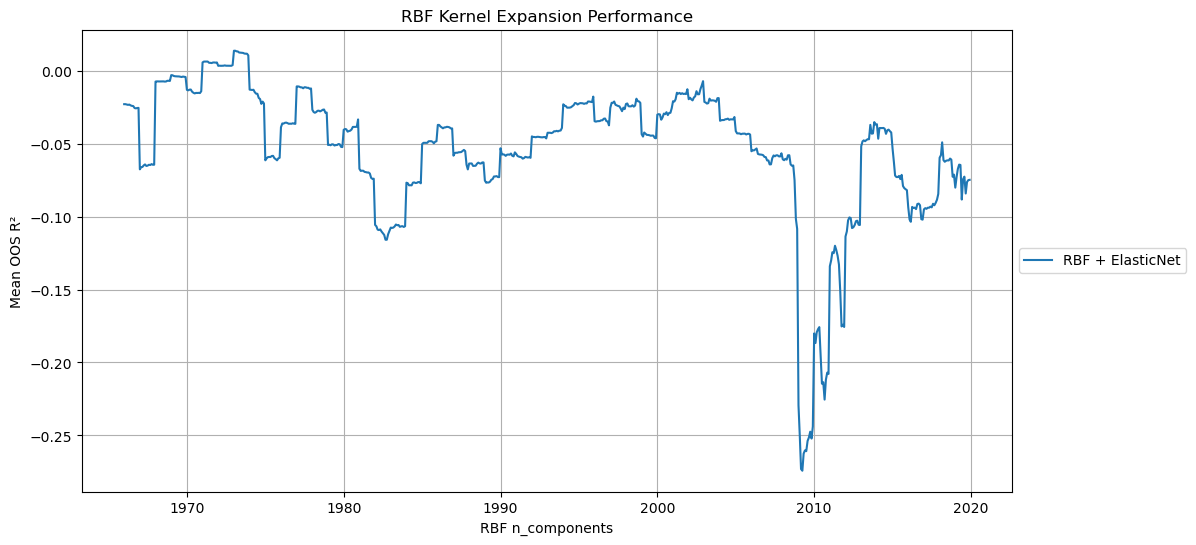

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Pipeline with RBF + ElasticNet
pipeline = Pipeline([
    ('rbf', RBFSampler(random_state=0)),
    ('enet', ElasticNet(max_iter=10000))
])

# Grid search over alpha
param_grid = {
    'enet__alpha': np.logspace(-4, 1, 10),
    'enet__l1_ratio': [.1, .3, 0.5, 0.7, 0.9, 0.99],
    'rbf__n_components': np.logspace(3, 4.5, num=4).astype(int),
    'rbf__gamma': [0.01, 0.1, 1.0, 10.0]
}

# Use a fixed early 120-month window for CV (or more if desired)
X_cv = df_plus.loc[start_year:start_year+pd.DateOffset(months=120), predictors_plus]
y_cv = df_plus.loc[start_year:start_year+pd.DateOffset(months=120), target]

tscv = TimeSeriesSplit(n_splits=10)
search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
display(search.fit(X_cv, y_cv))

final_model = Pipeline([
    ('rbf', RBFSampler(n_components=search.best_params_['rbf__n_components'], gamma=search.best_params_['rbf__gamma'], random_state=0)),
    ('enet', ElasticNet(alpha=search.best_params_['enet__alpha'], l1_ratio=search.best_params_['enet__l1_ratio'], max_iter=10000))
])

result = run_expanding_r2(
  df_plus.loc[start_year:, predictors_plus + ['re']], predictors_plus, target, test_dates,
  models_dict={'RBF + ElasticNet': final_model}, use_rbf=False, retrain_freq=12, window_size=120
)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, result['RBF + ElasticNet'], label=f'RBF + ElasticNet')
plt.xlabel("RBF n_components")
plt.ylabel("Mean OOS R²")
plt.title("RBF Kernel Expansion Performance")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend to the right outside of the plot
plt.grid(True)
plt.show()

